This notebook is a part of article [CardIO framework for deep research of electrocardiograms](https://medium.com/data-analysis-center/cardio-framework-for-deep-research-of-electrocardiograms-2a38a0673b8e) and contains code blocks from this article.

Some general imports

In [3]:
import os
import sys
sys.path.append(os.path.join(".."))

import cardio.dataset as ds
from cardio import EcgBatch
from cardio.models.metrics import classification_report

%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

env: CUDA_VISIBLE_DEVICES=0


Create indices from filenames

In [4]:
index = ds.FilesIndex(path="../cardio/tests/data/*.hea", no_ext=True, sort=True)

Check which indices are in list of indices

In [5]:
print(index.indices)

['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']


Create dataset

In [6]:
eds = ds.Dataset(index, batch_class=EcgBatch)

Generate batch

In [14]:
batch = eds.next_batch(batch_size=2)

Fill batch with data

In [15]:
batch_with_data = batch.load(fmt="wfdb", components=["signal", "meta"])

Plot short segment of ECG with index 'A00001'

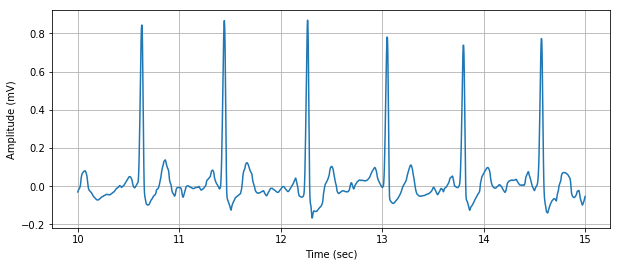

In [28]:
batch_with_data.show_ecg('A00001', start=10, end=15)

For detection of QRS intervals, P-waves and T-waves we need to train model first.

Download the [QT Database](https://www.physionet.org/physiobank/database/qtdb/) with labeled ECGs. Let ```SIGNALS_PATH``` be the folder where database is saved.

In [ ]:
from cardio.pipelines import hmm_preprocessing_pipeline, hmm_train_pipeline
import warnings
warnings.filterwarnings('ignore')

SIGNALS_PATH = "/notebooks/dpodvyaznikov/clada/ecg_report/Intenship_submit/QT/ecg_copy"
SIGNALS_MASK = os.path.join(SIGNALS_PATH, "*.hea")

index = ds.FilesIndex(path=SIGNALS_MASK, no_ext=True, sort=True)
dtst = ds.Dataset(index, batch_class=EcgBatch)

pipeline = hmm_preprocessing_pipeline()
ppl_inits = (dtst >> pipeline).run()

pipeline = hmm_train_pipeline(ppl_inits)
ppl_train = (dtst >> pipeline).run()

Save model

In [ ]:
ppl_train.save_model("HMM", path="model_dump.dll")

Let's make prediction with hmm model

In [23]:
from cardio.pipelines import hmm_predict_pipeline

res = (eds >> hmm_predict_pipeline("model_dump.dll")).run()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Functi

Plot ECG signal with detected QRS intervals, P-waves and T-waves

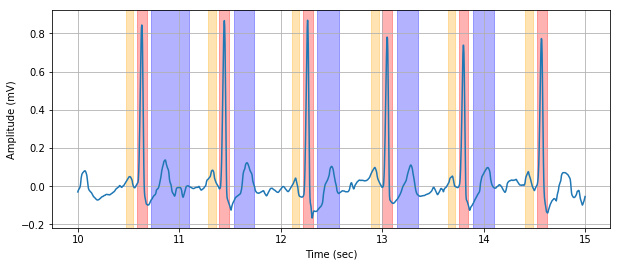

In [24]:
batch = res.get_variable("batch")[0]
batch.show_ecg('A00001', start=10, end=15, annotate=True)

For detection of atrial fibrillation we need to train another model.
Download the PhysioNet short single lead ECG database from [here](https://physionet.org/challenge/2017/). Let AF_SIGNALS_PATH be the folder where database is saved.

In [ ]:
from cardio.pipelines import dirichlet_train_pipeline

AF_SIGNALS_PATH = "/notebooks/data/ECG/training2017"
AF_SIGNALS_MASK = os.path.join(AF_SIGNALS_PATH, "*.hea")
AF_SIGNALS_REF = os.path.join(AF_SIGNALS_PATH, "REFERENCE.csv")

index = ds.FilesIndex(path=AF_SIGNALS_MASK, no_ext=True, sort=True)
afds = ds.Dataset(index, batch_class=EcgBatch)

pipeline = dirichlet_train_pipeline(AF_SIGNALS_REF)
train_ppl = (afds >> pipeline).run()

Save model

In [8]:
model_path = "af_model_dump"
train_ppl.save_model("dirichlet", path=model_path)

In [9]:
from cardio.pipelines import dirichlet_predict_pipeline

pipeline = dirichlet_predict_pipeline(model_path)
res = (eds >> pipeline).run()
pred = res.get_variable("predictions_list")

INFO:tensorflow:Restoring parameters from af_model_dump/model-33000


Get predicted probalilities for artrial fibrillation

In [10]:
print([x["target_pred"]["A"] for x in pred])

[0.019645154, 0.018440794, 0.60990381, 0.73341602, 0.017727474, 0.018212181]
